# Pipeline - Refactored

* Create a ROI (Region of Interest)
* Create a POI (Period of Interest)
* Download MODIS Data
* Download GOES16 Data

In [178]:
import autoroot
import os
import earthaccess
import xarray as xr
from dataclasses import dataclass
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

from dotenv import load_dotenv

## ROI

The first thing we need to do is find a region of interest.
We are going to do a very simple example where we define a bounding box.

In [2]:
from odc.geo.xr import xr_coords
from odc.geo.geom import BoundingBox
from odc.geo.geobox import GeoBox
from odc.geo.geom import Geometry
from odc.geo.crs import CRS

from odc.geo.data import ocean_geom, country_geom

In [3]:
# create a bounding box from xy
lon_bnds = [-70, -15]
lat_bnds = [20, 5]
bbox = BoundingBox.from_xy(x=lon_bnds, y=lat_bnds, crs="4326")

# initialize geobox
resolution = 0.25 # degrees
gbox = GeoBox.from_bbox(bbox, resolution=resolution, crs="4326")

# initialize geometry
odc_crs = CRS("EPSG:4326")
odc_geom = Geometry(geom=bbox.polygon)

### Download MODIS

In [79]:
from rs_tools._src.data.modis import MODISFileName, MODIS_ID_TO_NAME, MODIS_NAME_TO_ID

In [80]:
# environment variables
username = os.environ['EARTHDATA_USERNAME']
password = os.environ['EARTHDATA_PASSWORD']

In [100]:
satellite_name = "terra"
satellite_id = MODIS_NAME_TO_ID[satellite_name]
satellite_id

'MOD35_L2'

In [101]:
# Testing data download
# count: if set to a n, search_data returns the first n results - if n is greater than the number of results, all results are returned

results = earthaccess.search_data(
    short_name=satellite_id,
    cloud_hosted=True,
    # polygon=bbox.aoi,
    bounding_box=bbox.bbox,
    temporal=("2020-10-01 08:00", "2020-10-01 20:00"),
    count=-1
)

Granules found: 6


In [102]:
results[3]

Collection: {'ShortName': 'MOD35_L2', 'Version': '6.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -62.511322, 'Latitude': -11.761086}, {'Longitude': -41.184439, 'Latitude': -14.924663}, {'Longitude': -37.640584, 'Latitude': 3.063774}, {'Longitude': -58.478985, 'Latitude': 6.12279}, {'Longitude': -62.511322, 'Latitude': -11.761086}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2020-10-01T13:45:00.000Z', 'EndingDateTime': '2020-10-01T13:50:00.000Z'}}
Size(MB): 13.5900659561157
Data: ['https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD35_L2/2020/275/MOD35_L2.A2020275.1345.061.2020276012103.hdf']

In [8]:
earthaccess.download(results, "./")

 Getting 6 granules, approx download size: 0.95 GB


QUEUEING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

File MOD021KM.A2020275.1200.061.2020276011934.hdf already downloaded
File MOD021KM.A2020275.1340.061.2020276011930.hdf already downloaded
File MOD021KM.A2020275.1205.061.2020276011900.hdf already downloaded
File MOD021KM.A2020275.1345.061.2020276011850.hdf already downloaded
File MOD021KM.A2020275.1520.061.2020276012343.hdf already downloaded
File MOD021KM.A2020275.1515.061.2020276012851.hdf already downloaded


PROCESSING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/6 [00:00<?, ?it/s]

['MOD021KM.A2020275.1200.061.2020276011934.hdf',
 'MOD021KM.A2020275.1205.061.2020276011900.hdf',
 'MOD021KM.A2020275.1340.061.2020276011930.hdf',
 'MOD021KM.A2020275.1345.061.2020276011850.hdf',
 'MOD021KM.A2020275.1515.061.2020276012851.hdf',
 'MOD021KM.A2020275.1520.061.2020276012343.hdf']

### MODIS Files

In [34]:
from rs_tools._src.geoprocessing.modis import MODIS_WAVELENGTHS, parse_modis_dates_from_file, format_modis_dates

In [89]:
from rs_tools._src.utils.io import get_list_filenames

# list of modis files
modis_files = get_list_filenames("./", ".hdf")

# filter files for terra files ONLY
modis_files = list(filter(lambda x: satellite_id in x, modis_files))

modis_files

['./MOD021KM.A2020275.1200.061.2020276011934.hdf',
 './MOD021KM.A2020275.1205.061.2020276011900.hdf',
 './MOD021KM.A2020275.1340.061.2020276011930.hdf',
 './MOD021KM.A2020275.1345.061.2020276011850.hdf',
 './MOD021KM.A2020275.1515.061.2020276012851.hdf',
 './MOD021KM.A2020275.1520.061.2020276012343.hdf']

In [90]:
# grab dates
unique_times = list(set(map(parse_modis_dates_from_file, modis_files)))
unique_times

['2020275.1345',
 '2020275.1205',
 '2020275.1200',
 '2020275.1515',
 '2020275.1340',
 '2020275.1520']

### Preprocess MODIS

#### Radiances

In [91]:
import pandas as pd
from satpy import Scene
from rs_tools._src.geoprocessing.modis import MODIS_WAVELENGTHS
from rs_tools import get_modis_channel_numbers
from rs_tools._src.geoprocessing.modis.reproject import add_modis_crs

def preprocess_modis_image_radiances(file: str, satellite=""):

    identifier = MODIS_NAME_TO_ID[self.satellite]

    # load file with satpy
    scn = Scene(
        reader="modis_l1b",
        filenames=[file,]
    )

    # get channels
    channels = get_modis_channel_numbers()

    # load image
    scn.load(channels, generate=False, calibration='radiance')

    # convert to xarray
    ds = scn.to_xarray_dataset()

    # Store the attributes in a dict before concatenation
    attrs_dict = {x: ds[x].attrs for x in channels}

    # concatinate in new band dimension, and defining a new variable name
    # NOTE: Concatination overwrites attrs of bands.
    ds = ds.assign(Rad=xr.concat(list(map(lambda x: ds[x], channels)), dim="band"))
    # drop duplicate variables
    ds = ds.drop_vars(list(map(lambda x: x, channels)))

    # ================
    # COORDINATES
    # ================
    # rename band dimensions
    ds = ds.assign_coords(band=list(map(lambda x: x, channels)))

    # convert measurement time (in seconds) to datetime
    time_stamp = pd.to_datetime(ds.attrs['start_time'])
    time_stamp = time_stamp.strftime("%Y-%m-%d %H:%M")  
    # assign bands and time data to each variable
    ds = ds.assign_coords({"time": [time_stamp]})

    # assign band wavelengths
    ds = ds.assign_coords({"band_wavelength": list(MODIS_WAVELENGTHS.values())})


    # ================
    # ATTRIBUTES
    # ================

    # NOTE: Keep only certain relevant attributes
    ds.attrs = {}
    ds.attrs = dict(
        calibration=attrs_dict[list(attrs_dict.keys())[0]]["calibration"],
        standard_name=attrs_dict[list(attrs_dict.keys())[0]]["standard_name"],
        platform_name=attrs_dict[list(attrs_dict.keys())[0]]["platform_name"],
        sensor=attrs_dict[list(attrs_dict.keys())[0]]["sensor"],
        units=attrs_dict[list(attrs_dict.keys())[0]]["units"],
    )

    return ds


In [92]:
from rs_tools._src.data.modis import MODISFileName, MODIS_ID_TO_NAME, MODIS_NAME_TO_ID


satellite_id = MODIS_NAME_TO_ID[satellite_name]
satellite_name, satellite_id

('terra', 'MOD021KM')

In [164]:
ds = preprocess_modis_image(files[0])
ds = ds.fillna(-999)
ds

<xarray.Dataset> Size: 440MB
Dimensions:          (band: 38, y: 2030, x: 1354, time: 1, band_wavelength: 38)
Coordinates:
    crs              object 8B +proj=longlat +ellps=WGS84 +type=crs
    latitude         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    longitude        (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
  * band             (band) <U4 608B '1' '2' '3' '4' ... '35' '36' '13hi' '14hi'
  * time             (time) <U16 64B '2020-10-01 12:00'
  * band_wavelength  (band_wavelength) float64 304B 0.645 0.8585 ... 13.94 14.23
Dimensions without coordinates: y, x
Data variables:
    Rad              (band, y, x) float32 418MB dask.array<chunksize=(1, 1540, 1354), meta=np.ndarray>
Attributes:
    calibration:    radiance
    standard_name:  toa_outgoing_radiance_per_unit_wavelength
    platform_name:  EOS-Terra
    sensor:         modis
    units:          Watts/m^2/micrometer/steradian

In [182]:
from georeader.dataarray import fromDataArray, toDataArray
from georeader.read import read_reproject

In [166]:
geoda.shape

(38, 2030, 1354)

In [201]:
from georeader.slices import create_windows

In [205]:
window_size = (64, 64)
overlap = (10, 10)
windows = create_windows(geoda.shape, window_size=window_size, overlap=overlap, include_incomplete=False)

In [219]:
ipatch = geoda.read_from_window(windows[0])

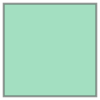

In [226]:
ipatch.footprint()

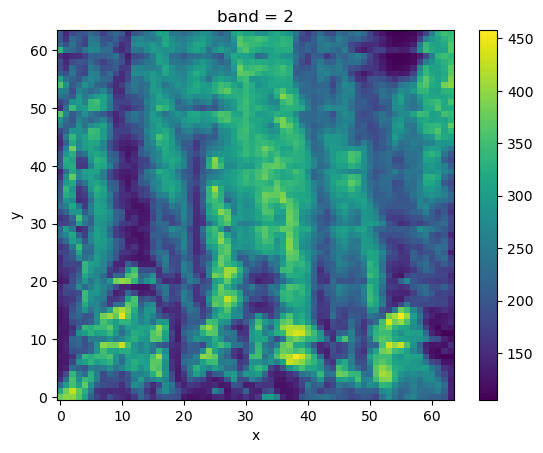

In [208]:

fig, ax = plt.subplots()

toDataArray(ipatch, ).isel(band=2).plot(ax=ax)
plt.show()

In [168]:
geoda = fromDataArray(ds.Rad, crs=ds.crs.values, x_axis_name="x", y_axis_name="y", fill_value_default=-999)
geoda

 
         Transform: | 1.00, 0.00,-0.50|
| 0.00, 1.00,-0.50|
| 0.00, 0.00, 1.00|
         Shape: (38, 2030, 1354)
         Resolution: (np.float64(1.0), np.float64(1.0))
         Bounds: (-0.5, -0.5, 1353.5, 2029.5)
         CRS: +proj=longlat +ellps=WGS84 +type=crs
         fill_value_default: -999
        

In [ ]:
# initialize geobox
resolution = 0.25 # degrees
gbox = GeoBox.from_bbox(bbox, resolution=resolution, crs="4326")

In [180]:
geoda_new = geoda.resize(output_shape=(100,100))
geoda_new

 
         Transform: | 20.30, 0.00,-0.50|
| 0.00, 13.54,-0.50|
| 0.00, 0.00, 1.00|
         Shape: (38, 100, 100)
         Resolution: (np.float64(20.3), np.float64(13.54))
         Bounds: (np.float64(-0.5), np.float64(-0.5), np.float64(2029.5), np.float64(1353.5))
         CRS: +proj=longlat +ellps=WGS84 +type=crs
         fill_value_default: -999
        

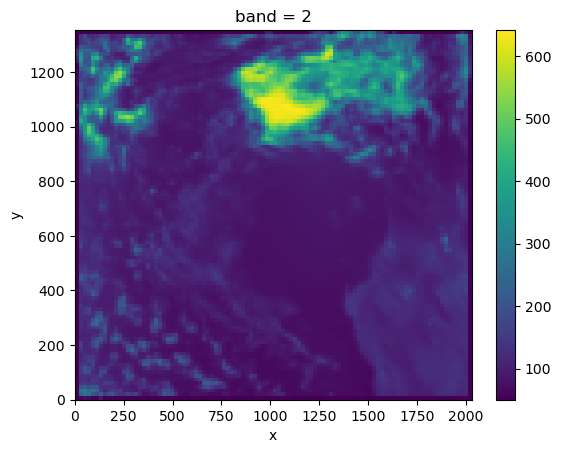

In [200]:
fig, ax = plt.subplots()

toDataArray(geoda_new, ).isel(band=2).plot(ax=ax)
plt.show()

In [52]:
fromDataArray(ds.Rad, x_axis_name="x", y_axis_name="y")

 
         Transform: | 1.00, 0.00,-0.50|
| 0.00, 1.00,-0.50|
| 0.00, 0.00, 1.00|
         Shape: (38, 2030, 1354)
         Resolution: (np.float64(1.0), np.float64(1.0))
         Bounds: (-0.5, -0.5, 1353.5, 2029.5)
         CRS: None
         fill_value_default: None
        

#### Clouds

In [109]:
satellite_name = "terra_cloud"
satellite_id = MODIS_NAME_TO_ID[satellite_name]
satellite_id

'MOD35_L2'

In [103]:
# Testing data download
# count: if set to a n, search_data returns the first n results - if n is greater than the number of results, all results are returned

results = earthaccess.search_data(
    short_name=satellite_id,
    cloud_hosted=True,
    # polygon=bbox.aoi,
    bounding_box=bbox.bbox,
    temporal=("2020-10-01 08:00", "2020-10-01 20:00"),
    count=-1
)

Granules found: 6


In [104]:
earthaccess.download(results, "./")

 Getting 6 granules, approx download size: 0.08 GB


QUEUEING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/6 [00:00<?, ?it/s]

['MOD35_L2.A2020275.1200.061.2020276012139.hdf',
 'MOD35_L2.A2020275.1205.061.2020276012102.hdf',
 'MOD35_L2.A2020275.1340.061.2020276012147.hdf',
 'MOD35_L2.A2020275.1345.061.2020276012103.hdf',
 'MOD35_L2.A2020275.1515.061.2020276013120.hdf',
 'MOD35_L2.A2020275.1520.061.2020276012530.hdf']

In [130]:
from rs_tools._src.geoprocessing.modis import MODIS_WAVELENGTHS, parse_modis_dates_from_file, format_modis_dates

In [131]:
from rs_tools._src.utils.io import get_list_filenames

# list of modis files
modis_files = get_list_filenames("./", ".hdf")

# filter files for terra files ONLY
modis_files = list(filter(lambda x: satellite_id in x, modis_files))

modis_files

['./MOD35_L2.A2020275.1200.061.2020276012139.hdf',
 './MOD35_L2.A2020275.1205.061.2020276012102.hdf',
 './MOD35_L2.A2020275.1340.061.2020276012147.hdf',
 './MOD35_L2.A2020275.1345.061.2020276012103.hdf',
 './MOD35_L2.A2020275.1515.061.2020276013120.hdf',
 './MOD35_L2.A2020275.1520.061.2020276012530.hdf']

In [132]:
# grab dates
unique_times = list(set(map(parse_modis_dates_from_file, modis_files)))
unique_times

['2020275.1345',
 '2020275.1205',
 '2020275.1200',
 '2020275.1515',
 '2020275.1340',
 '2020275.1520']

In [133]:
# load file with satpy
scn = Scene(
    reader="modis_l2",
    filenames=[modis_files[0],]
)
scn.available_dataset_names()

['cloud_mask', 'latitude', 'longitude', 'quality_assurance']

In [210]:
from typing import List
import pandas as pd
from satpy import Scene
from rs_tools._src.geoprocessing.modis import MODIS_WAVELENGTHS
from rs_tools import get_modis_channel_numbers
from rs_tools._src.geoprocessing.modis.reproject import add_modis_crs

def preprocess_modis_image_cloud_mask(file: str, satellite=""):

    # load file with satpy
    scn = Scene(
        reader="modis_l2",
        filenames=[file,]
    )

    # get list of datasets
    list_of_datasets: List[str] = scn.available_dataset_names()

    # load image
    scn.load(list_of_datasets, generate=False, resolution=1000) 

    # convert to xarray
    ds = scn.to_xarray_dataset()

    return ds


In [211]:
ds_mask = preprocess_modis_image_clouds(modis_files[0])
ds_mask

<xarray.Dataset> Size: 5MB
Dimensions:            (y: 2030, x: 1354)
Coordinates:
    crs                object 8B +proj=longlat +ellps=WGS84 +type=crs
Dimensions without coordinates: y, x
Data variables:
    quality_assurance  (y, x) uint8 3MB dask.array<chunksize=(2030, 1354), meta=np.ndarray>
    cloud_mask         (y, x) uint8 3MB dask.array<chunksize=(2030, 1354), meta=np.ndarray>
Attributes:
    resolution:           1000
    modifiers:            ()
    reader:               modis_l2
    sensor:               modis
    platform_name:        EOS-Terra
    ancillary_variables:  []
    start_time:           2020-10-01 12:00:00
    rows_per_scan:        10
    end_time:             2020-10-01 12:05:00

In [217]:
def combine_radiance_and_clouds(ds_rad, ds_clouds):

    # save cloud mask as data coordinate
    ds_rad = ds_rad.assign_coords({"cloud_mask": (("y", "x"), ds_clouds["cloud_mask"].values)})
    
    # add cloud mask attrs to dataset
    ds_rad["cloud_mask"].attrs = ds_clouds.attrs
    
    # remove crs from dataset
    ds_rad = ds_rad.drop_vars("crs")
    # ds_rad = ds_rad.drop_vars("spatial_ref")

    # remove attrs that cause netcdf error
    for attr in [
        "start_time", 
        "end_time", 
        # "area", 
        # "_satpy_id"
    ]:
        ds_rad["cloud_mask"].attrs.pop(attr)


    for var in ds.data_vars:
        ds_rad[var].attrs = {}


    return ds_rad

In [218]:
combine_radiance_and_clouds(ds, ds_mask)

<xarray.Dataset> Size: 443MB
Dimensions:          (band: 38, y: 2030, x: 1354, time: 1, band_wavelength: 38)
Coordinates:
    latitude         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    longitude        (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
  * band             (band) <U4 608B '1' '2' '3' '4' ... '35' '36' '13hi' '14hi'
  * time             (time) <U16 64B '2020-10-01 12:00'
  * band_wavelength  (band_wavelength) float64 304B 0.645 0.8585 ... 13.94 14.23
    cloud_mask       (y, x) uint8 3MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Dimensions without coordinates: y, x
Data variables:
    Rad              (band, y, x) float32 418MB dask.array<chunksize=(1, 1540, 1354), meta=np.ndarray>
Attributes:
    calibration:    radiance
    standard_name:  toa_outgoing_radiance_per_unit_wavelength
    platform_name:  EOS-Terra
    sensor:         modis
    units:          Watts/m^2/micrometer/steradian

In [144]:
from rs_tools import modis_download

In [146]:
# modis_download(
#     start_date="2020-10-01",
#     end_date="2020-10-01",
#     start_time 
# )

In [98]:
ds = xr.open_dataset(results[0].data_links()[0], engine="h5netcdf")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD021KM/2020/275/MOD021KM.A2020275.1200.061.2020276011934.hdf', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)